In [1]:
# Load in relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay# to get a display
from sklearn import metrics #Import scikit-learn metrics for evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Define relevant variables for the ML task
batch_size = 64 #can be altered
num_classes = 10 # based on data set
learning_rate = 0.001 #can be altered
num_epochs = 20 #can be altered

In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                         std=[0.2023, 0.1994, 0.2010])
                                    ])

In [5]:
# Create Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = True,
                                            transform = all_transforms,
                                            download = True)
# Create Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

100%|███████████████████████| 170498071/170498071 [00:02<00:00, 71582833.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170498071/170498071 [==============================] - 3s 0us/step


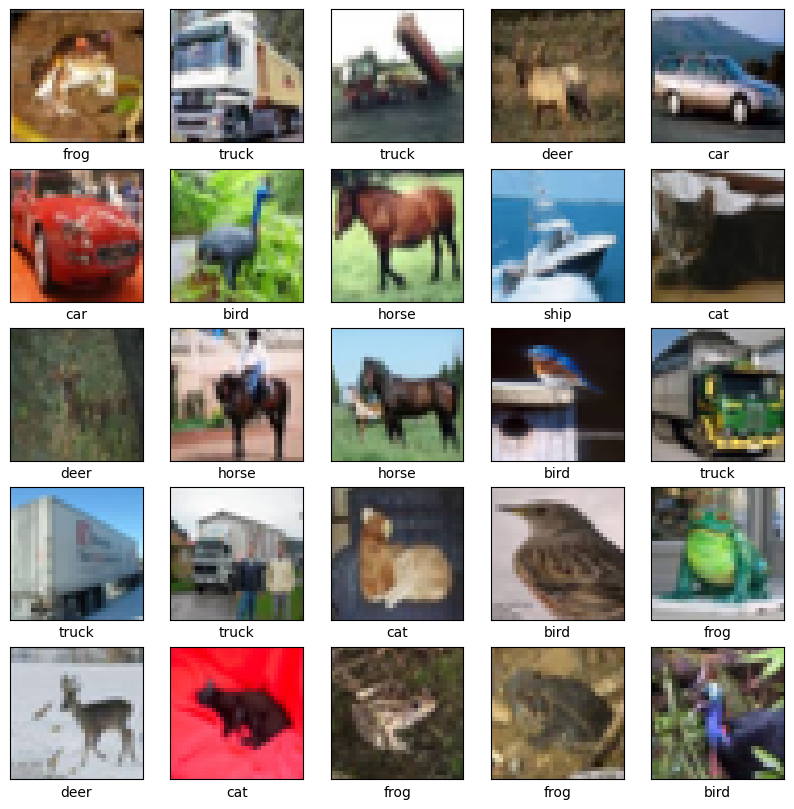

In [65]:
from tensorflow.keras import datasets, layers, models

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship',
'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset.data[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [11]:
# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = True)

In [12]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    # Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [13]:
model = ConvNeuralNet(num_classes)
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()
# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005,
momentum = 0.9)

In [15]:
# We use the pre-defined number of epochs to determine how many iterations to train the
#network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [20/20], Loss: 0.9654


In [17]:
X = torch.tensor([train_dataset.data[7]], dtype=torch.float32).permute(0,3,1,2)
model.eval()
with torch.no_grad():
    feature_maps = model.conv_layer1(X)

/tmp/ipykernel_2759714/2835579177.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor([train_dataset.data[7]], dtype=torch.float32).permute(0,3,1,2)


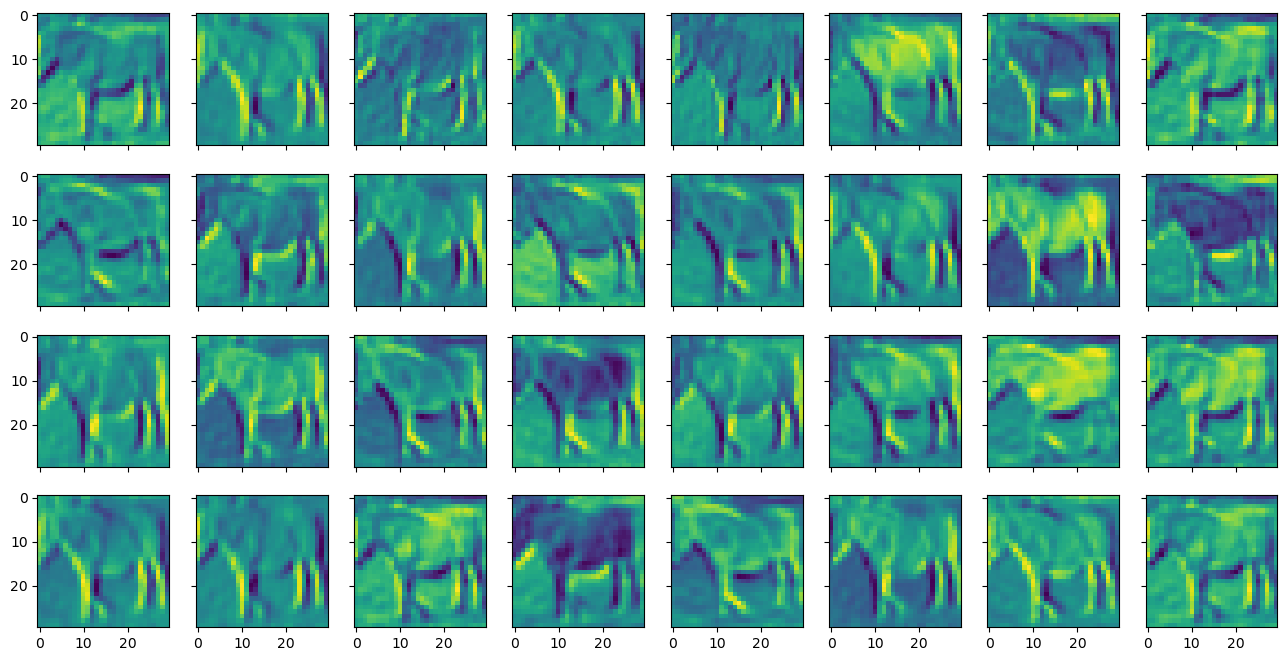

In [18]:
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

In [47]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 50000 train images: {100 * correct / total} %')

Accuracy of the network on the 50000 train images: 84.462 %


In [111]:
prediction=[]
actual = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        #actual.extend(outputs.data)
        #prediction.extend(predicted.data)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # FOUND THIS ONLINE - since metrics wasn't working due to comparison of tensors
        #not being accepted from the two commented line previous
        labels = labels.detach().cpu().numpy()
        y_hat = outputs.detach().cpu().numpy()
        #max here is 16 for some reason
        for i in range(16):
            actual.append(labels[i])
            prediction.append(y_hat[i,:])

actual = np.asarray(actual)
prediction = np.asarray(prediction)
            
if prediction.shape[1] > 1: #We have a classification problem, convert to labels
    prediction = np.argmax(prediction, axis=1)

print(f'Accuracy of the network on the 10000 train images: {100 * correct / total} %')

Accuracy of the network on the 10000 train images: 68.66 %


## Note:
#### I had to change the way the above worked. I tried making it work for an hour or two before finding a solution online that seems pretty consistent with the accuracy above. I think there's something a little off since the two arrays only have ~2500 entries compared to the 10000 I thought it should have, but couldn't figure out what part.

In [112]:
actual

array([1, 6, 6, ..., 8, 0, 9])

In [113]:
prediction

array([1, 3, 6, ..., 8, 0, 9])

In [114]:
print(f"Accuracy: {metrics.accuracy_score(actual, prediction)}")

Accuracy: 0.6882961783439491


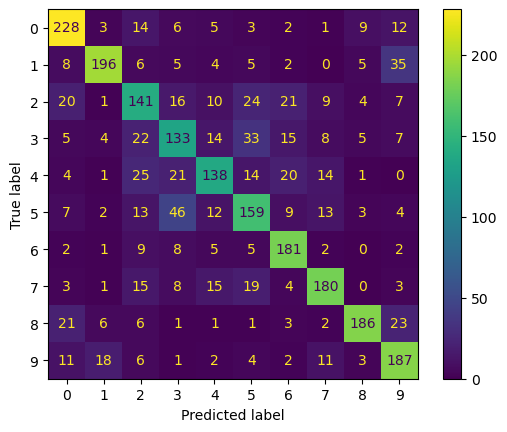

In [115]:
conf_mat = confusion_matrix(actual, prediction)
cm_display = ConfusionMatrixDisplay(conf_mat).plot()

In [116]:
print(metrics.classification_report(actual,prediction))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       283
           1       0.84      0.74      0.79       266
           2       0.55      0.56      0.55       253
           3       0.54      0.54      0.54       246
           4       0.67      0.58      0.62       238
           5       0.60      0.59      0.59       268
           6       0.70      0.84      0.76       215
           7       0.75      0.73      0.74       248
           8       0.86      0.74      0.80       250
           9       0.67      0.76      0.71       245

    accuracy                           0.69      2512
   macro avg       0.69      0.69      0.69      2512
weighted avg       0.69      0.69      0.69      2512



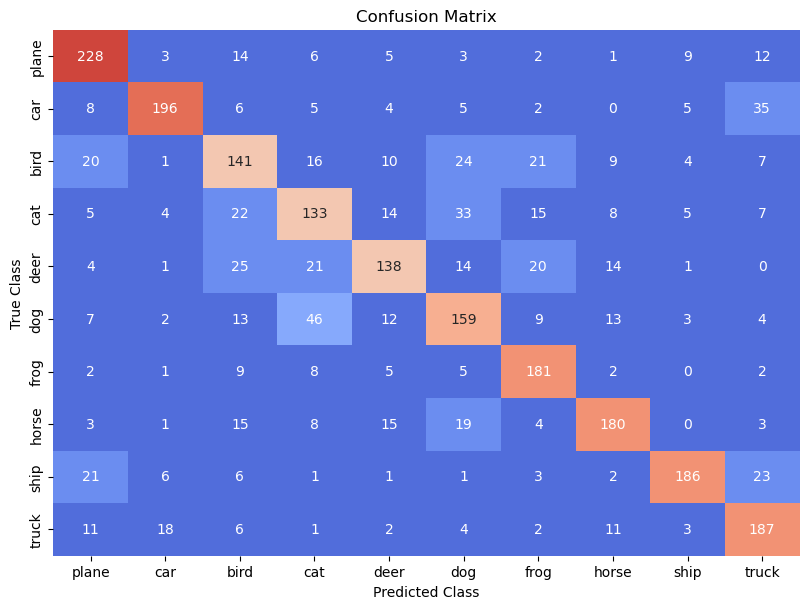

In [117]:
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship',
'truck']

# Create pandas dataframe
dataframe = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
# Create heatmap
sn.heatmap(dataframe, annot=True, cbar=None,cmap=sn.color_palette("coolwarm", 12),fmt="d") #you can pick a
#different color map (cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()

# Question Page 11
<p>Class -> Most missclassified to<br/>plane->bird<br/>car->truck<br/>bird->dog<br/>cat->dog<br/>deer->bird<br/>dog->cat<br/>frog->bird<br/>horse->dog<br/>ship->truck<br/>truck->car<br/>There were a few of these that surprised me, specifically the bird to dog and deer to bird.But, from the above matrix, it seems like the class images were most 
misclassified towards was dogs. They seem to have the most in general. I also thought it was funny that the most misclassified dogs were predicted to be cats. It also was able to classify most planes and cars correctly. The one that had the most misclassified was cats with birds being pretty close. </p>

In [118]:
#Look at the other results
print(metrics.classification_report(actual,prediction, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.74      0.81      0.77       283
         car       0.84      0.74      0.79       266
        bird       0.55      0.56      0.55       253
         cat       0.54      0.54      0.54       246
        deer       0.67      0.58      0.62       238
         dog       0.60      0.59      0.59       268
        frog       0.70      0.84      0.76       215
       horse       0.75      0.73      0.74       248
        ship       0.86      0.74      0.80       250
       truck       0.67      0.76      0.71       245

    accuracy                           0.69      2512
   macro avg       0.69      0.69      0.69      2512
weighted avg       0.69      0.69      0.69      2512

